In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage import data, io, filters, color, exposure
from tensorflow.keras.models import load_model

2023-05-13 01:44:32.146175: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-13 01:44:32.220045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 01:44:34.082909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19, decode_predictions 

In [ ]:
# # Function to load and operate on the content and style images

# def get_data(img_path):
#     img = tf.io.read_file(img_path)
#     img = tf.image.decode_image(img, channels=3)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     img = img[tf.newaxis, :]
#     return img

In [6]:
## Function to convert and preprocess the image to arrays

def load_img(path_to_img):
  max_dim = 218
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, [218,178])
  img = img[tf.newaxis, :]
  return img

In [34]:
# content_image = get_data('/content/gdrive/MyDrive/Deep_Learning_Project/Dataset/Kiran_pic.jpg')
# style_image = get_data('/content/gdrive/MyDrive/Deep_Learning_Project/Dataset/Starry_night.png')

content_image = load_img('Dataset/Raw/img_align_celeba/000015.jpg')
style_image = load_img('Starry_night.png')

Text(0.5, 1.0, 'Style Image')

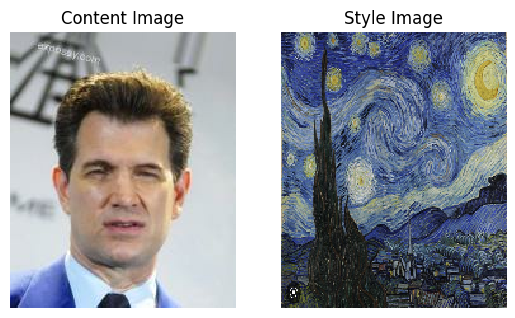

In [35]:
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(content_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Content Image')


plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [6]:
## Current layers in CNN (new_model not imported)

for layer in new_model.layers:
  print(layer.name)

conv2d_2
batch_normalization_1
conv2d_3
max_pooling2d_1
dropout_2
flatten_1
dense_2
dropout_3
dense_3


In [10]:
content_layers = ['conv2d_3']  ## CNN layer to be used for content

style_layers = [
                'conv2d_2'] ## CNN layer to be used for style

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [11]:
## Returns the layers based on name
def vgg_layers(layer_names):
    new_model = load_model('Saved_Models/Model_1_100_21.h5')
    new_model.trainable = False

    outputs = [new_model.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([new_model.input], outputs)
    return model

In [12]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

2023-05-13 01:51:29.276415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900


conv2d_2
  shape:  (216, 176, 32)
  min:  0.0
  max:  190.0572
  mean:  12.91312



2023-05-13 01:51:30.036391: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [13]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [25]:
"""
Creates the target values wrt content and style image. Image is trained wrt to those
"""

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    #preprocessed_input = preprocess_input(inputs)
    outputs = self.vgg(inputs)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

5
1


In [26]:
### Example Execution

extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   conv2d_2
    shape:  (1, 32, 32)
    min:  0.0
    max:  31930.39
    mean:  565.47595

Contents:
   conv2d_3
    shape:  (1, 214, 174, 64)
    min:  0.0
    max:  14.865456
    mean:  0.28359482


In [44]:
## Getting the targets

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [57]:
## Generated image
image = tf.Variable(content_image)


In [17]:
# Since this is a float image, define a function to keep the pixel values between 0 and 1:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [56]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-3
content_weight=1e-2

In [40]:
## Defining the loss function for training

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [58]:
## Training definition

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [59]:
## Training
epochs = 1000

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


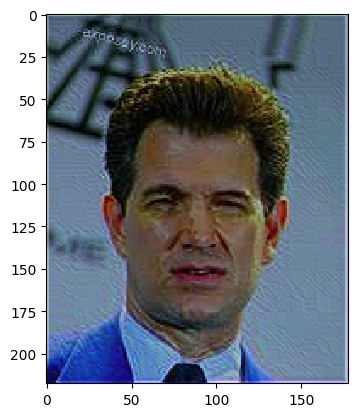

In [60]:
## Displaying the generated image

plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')

## Guernica

In [61]:
style_image = load_img('Guernica.png')

Text(0.5, 1.0, 'Style Image')

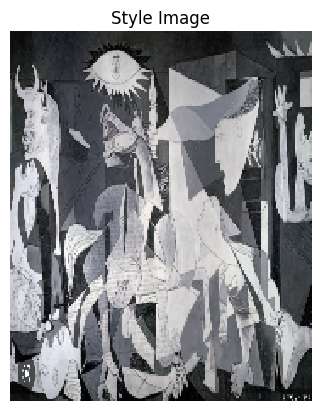

In [62]:
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [63]:
## Getting the targets

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [64]:
## Generated image
image = tf.Variable(content_image)

In [65]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e-2

In [66]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [67]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [70]:
## Training
epochs = 1500

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400


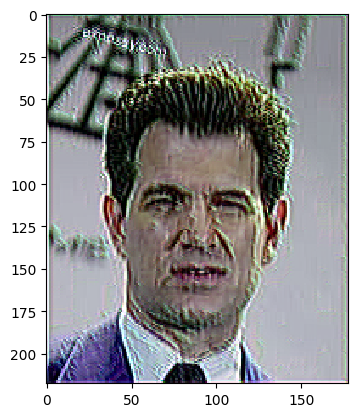

In [71]:
plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')